In [209]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [210]:
pagos = pd.read_csv("../../data/interim/pagos.csv")
#expensas = pd.read_csv("../../data/interim/expensas.csv")
#unidades = pd.read_csv("../../data/interim/unidades.csv")

## Pagos

In [211]:
pagos.shape

(299354, 4)

In [212]:
pagos.columns

Index(['fecha_pago', 'monto_pago', 'expensa_id', 'metodo_pago'], dtype='object')

In [213]:
pagos.dtypes

fecha_pago      object
monto_pago     float64
expensa_id       int64
metodo_pago     object
dtype: object

Aqui podemos observar que los tipos no son correctos, cambiamos la columna de expensa_id como string, para que no sacar métricas numericas innecesarias y configuramos la columna de fecha ocmo datetime

In [214]:
pagos.expensa_id = pagos.expensa_id.map(str)
pagos.fecha_pago = pd.to_datetime(pagos.fecha_pago)

In [215]:
pagos.dtypes

fecha_pago     datetime64[ns]
monto_pago            float64
expensa_id             object
metodo_pago            object
dtype: object

In [216]:
pagos = pagos.loc[(pagos.fecha_pago >= '2013-01-01') & (pagos.fecha_pago < '2019-01-01'),:]

In [217]:
pagos.shape

(255488, 4)

In [218]:
pagos["day"] = pagos.fecha_pago.dt.day
pagos["dayofweek"] = pagos.fecha_pago.dt.dayofweek
days = ["Lunes", "Martes", "Miercoles", "Jueves", "Viernes", "Sabado", "Domingo"]
pagos["day_name"] =  pagos.dayofweek.map(lambda number: days[int(number)])

### Monto

In [219]:
pagos.describe()

,monto_pago,day,dayofweek
count,2.554880e+05,255488.000000,255488.000000
mean,1.717503e+03,12.109543,2.205219
std,3.380789e+03,7.451763,1.572547
min,1.000000e-02,1.000000,0.000000
25%,5.351000e+02,7.000000,1.000000
50%,1.272980e+03,10.000000,2.000000
75%,2.335980e+03,16.000000,3.000000
max,1.003318e+06,31.000000,6.000000


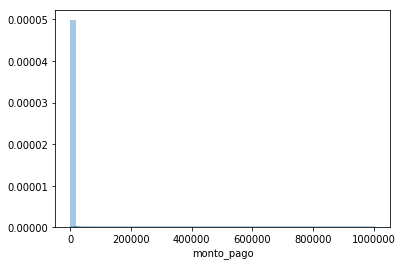

In [220]:
sns.distplot(pagos.monto_pago)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


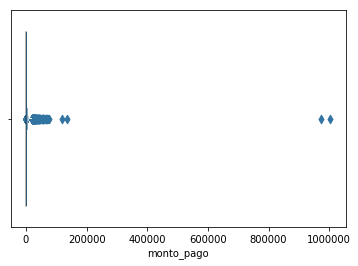

In [221]:
sns.boxenplot(pagos.monto_pago)

Por lo que se puede ver, hay pagos que son muy grandes y que deforman la distribución. Hay que revisar que hacer con ellos, pueden corresponder a expensas que sean para cancelación de deuda, las cuales no seran tenidas en cuenta. Por el momento lo filtraremos para poder analizar un poco mejor la distribución real de los datos

In [222]:
pagos_aux = pagos.loc[pagos.monto_pago < 10000,:]

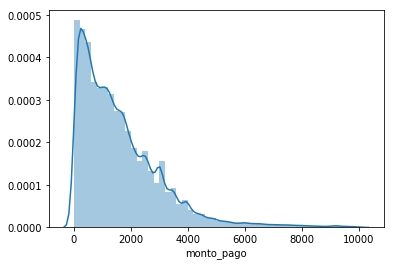

In [223]:
sns.distplot(pagos_aux.monto_pago)

Deberia chequear como funciona los saldos a favor y las notas de credito.

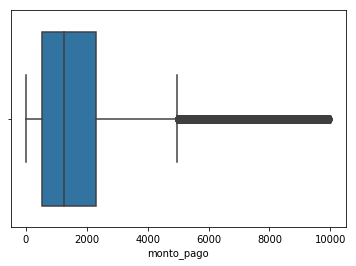

In [224]:
sns.boxplot(pagos_aux.monto_pago)

Hay que tener en cuenta que estas medidas no son muy representativas, dada la inflación en Argentina. Es decir cada año los pagos son mas y mas caros

### Metodos de pago

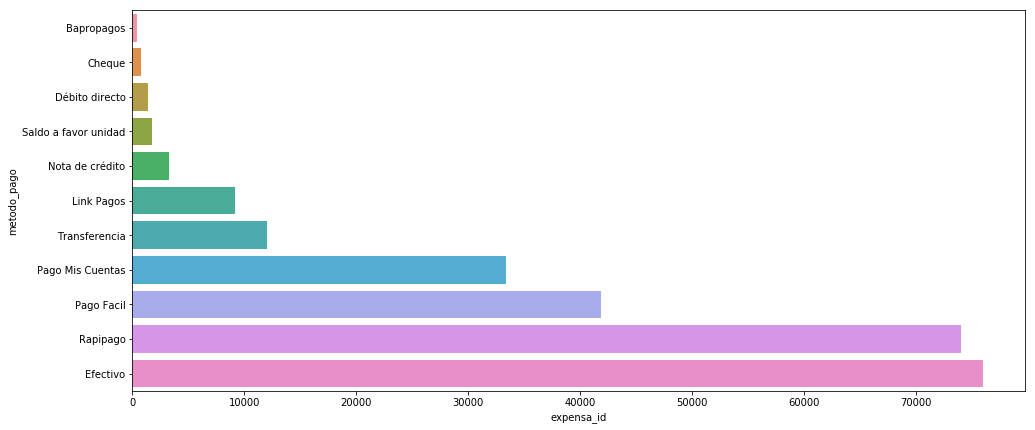

In [225]:
plt.figure(figsize=(16,7))
sns.barplot(data=pagos_aux.groupby(by="metodo_pago").count().reset_index().sort_values(by="expensa_id"), x="expensa_id", y="metodo_pago")

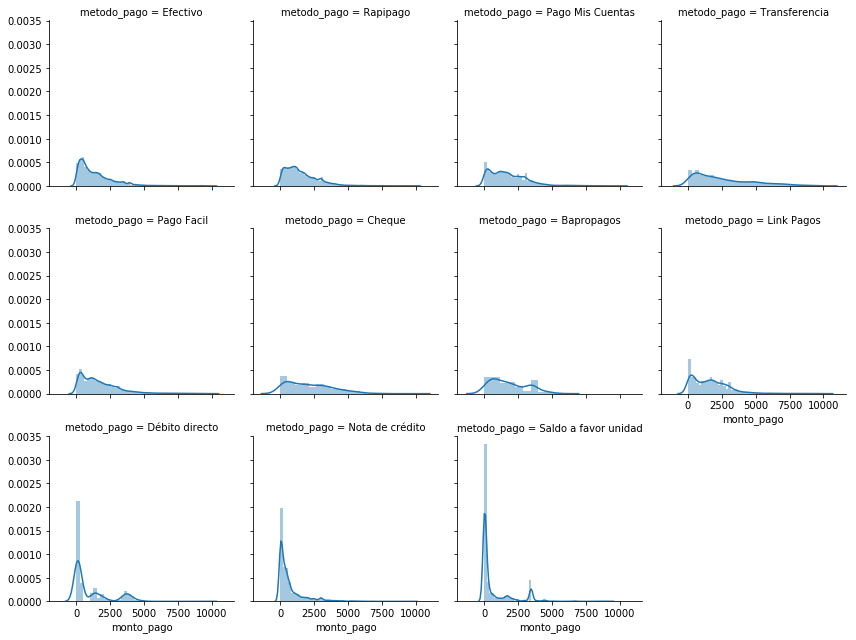

In [226]:
grid = sns.FacetGrid(pagos_aux, col="metodo_pago", col_wrap = 4)
grid.map(sns.distplot, "monto_pago")

Los meotdos de pagos **Nota de crédito** y **Saldo a favor** son mecanismos que se utilizan para saldar deudas con las unidades que se generan automaticamente, por lo que no deberian tener influencia directa en la mora

### Fecha

In [227]:
pagos_timeline = pagos[["fecha_pago", "monto_pago"]]
pagos_cantidad_fecha = pagos_timeline.groupby("fecha_pago").count().reset_index()
pagos_suma_fecha = pagos_timeline.groupby("fecha_pago").sum().reset_index()

In [228]:
def plot_timeline_complete(pagos):
    timeline = np.arange('2013-01-01', '2018-12-31', dtype='datetime64[D]')
    pagos_complete = pd.DataFrame((timeline,np.zeros(len(timeline))))
    pagos_complete = pagos_complete.T
    pagos_complete.columns = ["fecha_pago", "monto"]
    pagos_complete.fecha_pago = pd.to_datetime(pagos_complete.fecha_pago, format='%Y-%m-%d')

    pagos_complete = pagos_complete.merge(pagos, on="fecha_pago", how="left")
    pagos_complete = pagos_complete.fillna(0)
    pagos_complete["agregacion"] = pagos_complete.monto + pagos_complete.monto_pago
    pagos_complete = pagos_complete[["fecha_pago", "agregacion"]]

    plt.figure(figsize=(16,5))
    plt.plot(pagos_complete.fecha_pago, pagos_complete.agregacion)

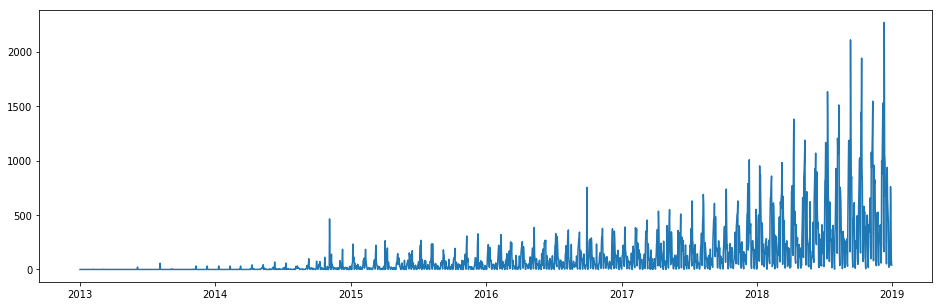

In [229]:
plot_timeline_complete(pagos_cantidad_fecha)

In [230]:
pagos_cantidad_fecha.loc[(pagos_cantidad_fecha.fecha_pago >= '2014-11-01') & (pagos_cantidad_fecha.fecha_pago <= '2014-11-30') ,:]

,fecha_pago,monto_pago
155,2014-11-03,14
156,2014-11-04,18
157,2014-11-05,464
158,2014-11-06,114
159,2014-11-07,59
160,2014-11-08,11
161,2014-11-10,140
162,2014-11-11,23
163,2014-11-12,48
164,2014-11-13,30


El **2014-11-05** es una fecha atipica, para analizar un poco

In [231]:
pagos_cantidad_fecha.loc[(pagos_cantidad_fecha.fecha_pago >= '2016-09-27') & (pagos_cantidad_fecha.fecha_pago <= '2016-10-2') ,:]

,fecha_pago,monto_pago
784,2016-09-27,36
785,2016-09-28,45
786,2016-09-29,753
787,2016-09-30,59
788,2016-10-01,7
789,2016-10-02,1


El **2016-09-29** es una fecha atipica, para analizar un poco

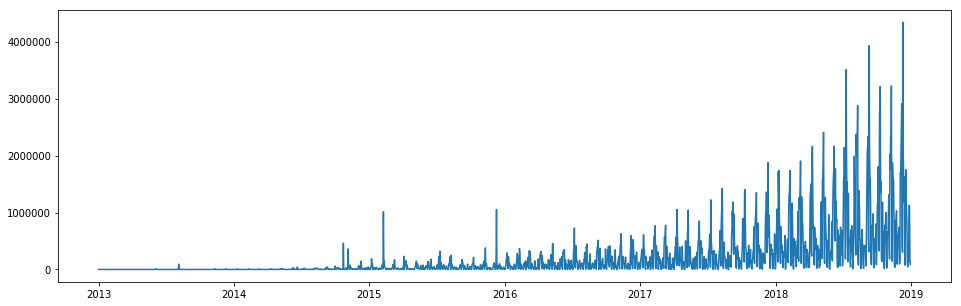

In [232]:
plot_timeline_complete(pagos_suma_fecha)

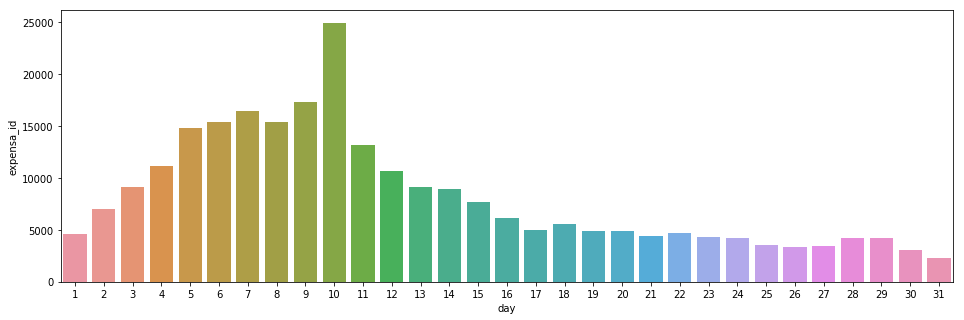

In [233]:
plt.figure(figsize=(16,5))
sns.barplot(data=pagos_aux.groupby(by="day").count().reset_index().sort_values(by="expensa_id"), y="expensa_id", x="day")

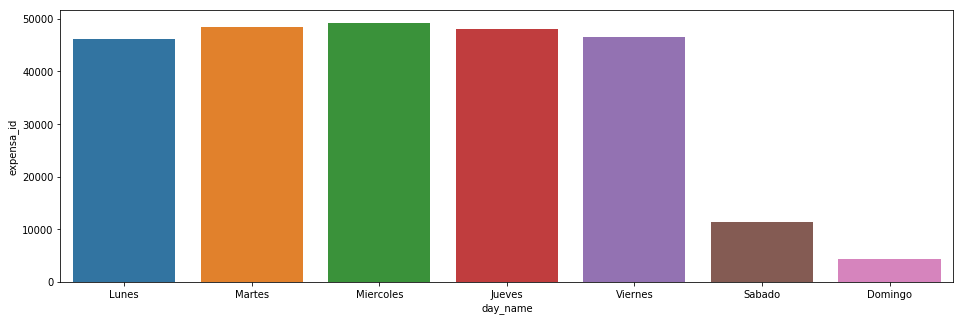

In [234]:
plt.figure(figsize=(16,5))
sns.barplot(data=pagos_aux.groupby(by=["dayofweek","day_name"]).count().reset_index(), y="expensa_id", x="day_name")

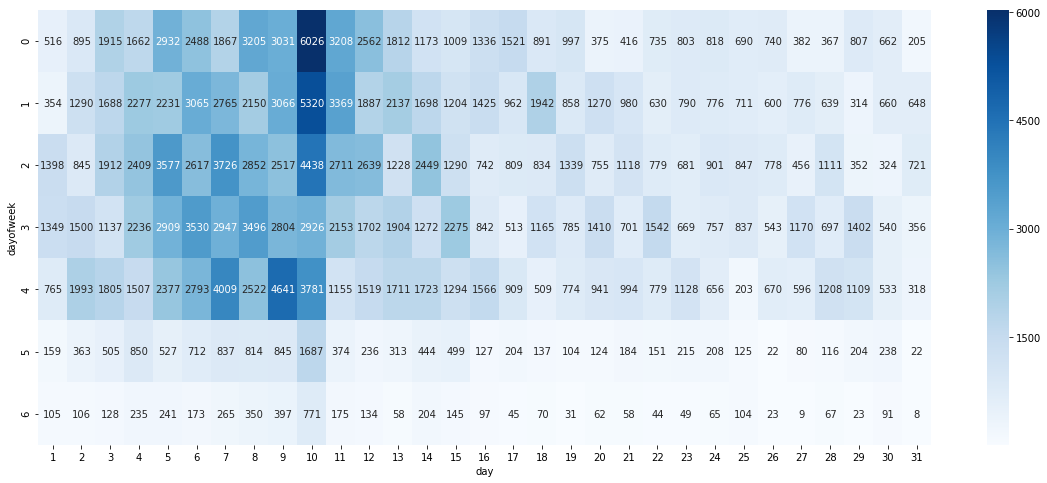

In [235]:
plt.figure(figsize=(20,8))
sns.heatmap(pagos_aux.groupby(["day","dayofweek"]).count().reset_index().pivot("dayofweek","day","monto_pago"), annot=True, fmt="d", cmap="Blues")

In [238]:
pagos_aux.groupby(["day","day_name","dayofweek"]).count().reset_index()[["day_name","day","monto_pago"]].sort_values("monto_pago", ascending=False).head(10)

,day_name,day,monto_pago
65,Lunes,10,6026
66,Martes,10,5320
62,Viernes,9,4641
67,Miercoles,10,4438
48,Viernes,7,4009
69,Viernes,10,3781
46,Miercoles,7,3726
32,Miercoles,5,3577
36,Jueves,6,3530
50,Jueves,8,3496


### que hay el 2014-11-05?

In [241]:
pagos_aux.loc[pagos_aux.fecha_pago == "2014-11-05",:].sort_values("expensa_id")

,fecha_pago,monto_pago,expensa_id,metodo_pago,day,dayofweek,day_name
351,2014-11-05,3208.89,1098,Efectivo,5,2,Miercoles
357,2014-11-05,3208.89,1099,Efectivo,5,2,Miercoles
363,2014-11-05,3208.89,1100,Efectivo,5,2,Miercoles
375,2014-11-05,3208.89,1101,Efectivo,5,2,Miercoles
345,2014-11-05,3208.89,1106,Efectivo,5,2,Miercoles
369,2014-11-05,3208.89,1108,Efectivo,5,2,Miercoles
399,2014-11-05,3208.89,1110,Efectivo,5,2,Miercoles
405,2014-11-05,3208.89,1111,Efectivo,5,2,Miercoles
411,2014-11-05,3208.89,1112,Efectivo,5,2,Miercoles
387,2014-11-05,3208.89,1121,Efectivo,5,2,Miercoles


Algo extraño pero por ahora no explicable

### que hay el 2016-09-29

In [242]:
pagos_aux.loc[pagos_aux.fecha_pago == "2016-09-29",:]

,fecha_pago,monto_pago,expensa_id,metodo_pago,day,dayofweek,day_name
15765,2016-09-29,2696.12,67898,Efectivo,29,3,Jueves
15766,2016-09-29,3671.02,67938,Efectivo,29,3,Jueves
15767,2016-09-29,416.86,68096,Efectivo,29,3,Jueves
15768,2016-09-29,1452.28,67930,Efectivo,29,3,Jueves
15769,2016-09-29,1324.31,72125,Efectivo,29,3,Jueves
15770,2016-09-29,2696.12,67769,Efectivo,29,3,Jueves
15771,2016-09-29,2458.55,71964,Efectivo,29,3,Jueves
15772,2016-09-29,416.86,67986,Efectivo,29,3,Jueves
15773,2016-09-29,380.12,72181,Efectivo,29,3,Jueves
15774,2016-09-29,416.86,68025,Efectivo,29,3,Jueves


### Feriados

In [ ]:
Feriados = [
    #2013
    '2013-01-01',
    '2013-01-31',
    '2013-02-11',
    '2013-02-12',
    '2013-02-20',
    '2013-03-28',
    '2013-03-29',
    '2013-04-01',
    '2013-04-02',
    '2013-05-01',
    '2013-06-20',
    '2013-06-21',
    '2013-07-09',
    '2013-08-19',
    '2013-10-14',
    '2013-11-25',
    '2013-12-25',
    #2014
    '2014-01-01',
    '2014-03-03',
    '2014-03-04',
    '2014-03-24',
    '2014-04-02',
    '2014-04-18',
    '2014-05-01',    
    '2014-05-02',
    '2014-06-20',
    '2014-07-09',
    '2014-08-18',
    '2014-10-13',
    '2014-11-24',
    '2014-12-25',    
    '2014-12-26',
    #2015
    '2015-01-01',
    '2015-02-16',
    '2015-02-17',
    '2015-03-23',
    '2015-03-24',
    '2015-04-02',
    '2015-04-03',
    '2015-05-01',    
    '2015-05-25',
    '2015-06-20',
    '2015-07-09',
    '2015-08-17',
    '2015-10-12',
    '2015-11-23',    
    '2015-12-07',   
    '2015-12-08',
    '2015-12-25',
]